In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from sklearn.tree import export_graphviz
from statsmodels.graphics.regressionplots import influence_plot
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials , space_eval
from sklearn.model_selection import cross_val_score

# About the dataset

In [5]:
# import dataset
data = pd.read_csv("Titanic_train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Is the data imbalanced?

In [8]:
data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

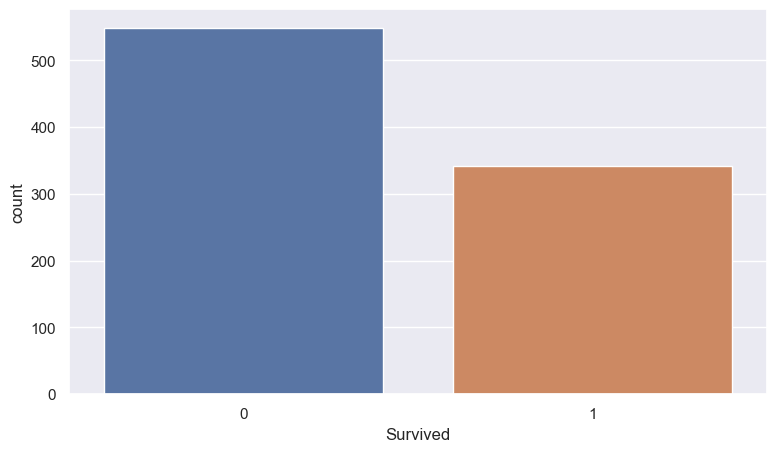

In [9]:
sns.set()
sns.set(rc = {'figure.figsize':(9,5)})
sns.countplot(x="Survived",data=data)

#### Data is clearly imbalanced, the count of people who survived is almost close to half the count of people who didn't survive

# EDA

# Age of the people who survived

### Three visualizations :

#### 1. Boxplots : To tell us about the distribution of the feature for each output class and give us an idea about the outliers in the data

#### 2. Density plots : To tell us about the distribution and more about the shape of the distribution (resembling normal or any other disb) of the feature

#### 3. Stacked countplots : Tells us more about count of each category of the feature with information about the percentage belonging to which output class


C:\Users\SAI\AppData\Local\Temp\ipykernel_5440\329628224.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'Density plot')

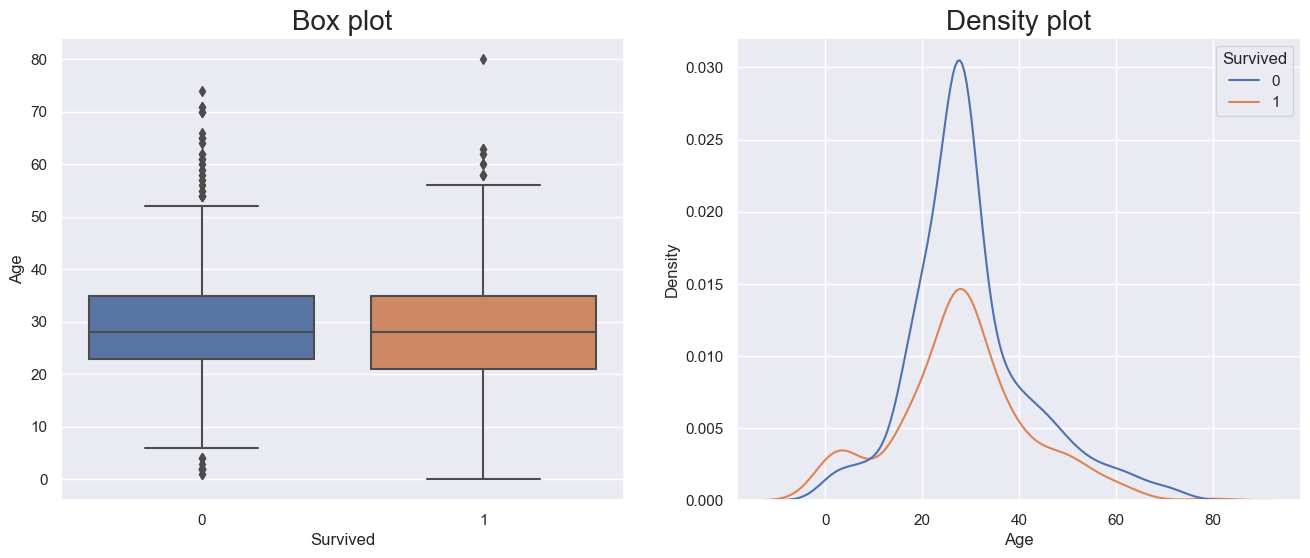

In [29]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Age", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Age', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

##### 1. Distribution of people who didn't survive is slightly right skewed, or the mean of the people who did not survive > median of the distribution which is around ~27, i.e. mean age of the people who did not survive is higher than 27

##### 2. People of ages > ~67 are considered outliers in the disb of people who did not survive. owing to the fact people above the age of ~67 are very less and people of age ~60 above are outliers in the disb of people who did survive, i.e. very few people above 60 actually did survive

In [30]:
def calculate_stacked_plot_percentages(df_plot, df_p):
    #Find the counts for each age bin for calcualting percentage
    df_plot_sum = df_plot.sum(axis=1)
    class_sum = np.array([df_plot_sum.iloc[int(i/2)] if i%2==0 else df_plot_sum.iloc[int((i-1)/2)] for i in range(2*len(df_plot_sum)) ]).reshape((len(df_plot_sum),2)).T.flatten()
    class_list = zip(np.roll(df_plot.to_numpy().T.flatten(), len(df_plot)), class_sum, list(df_p.axes.patches))

    return class_list

Survived        0    1
age_bin               
(-0.1, 27.0]  189  130
(27.0, 53.0]  326  196
(53.0, 80.0]   34   16


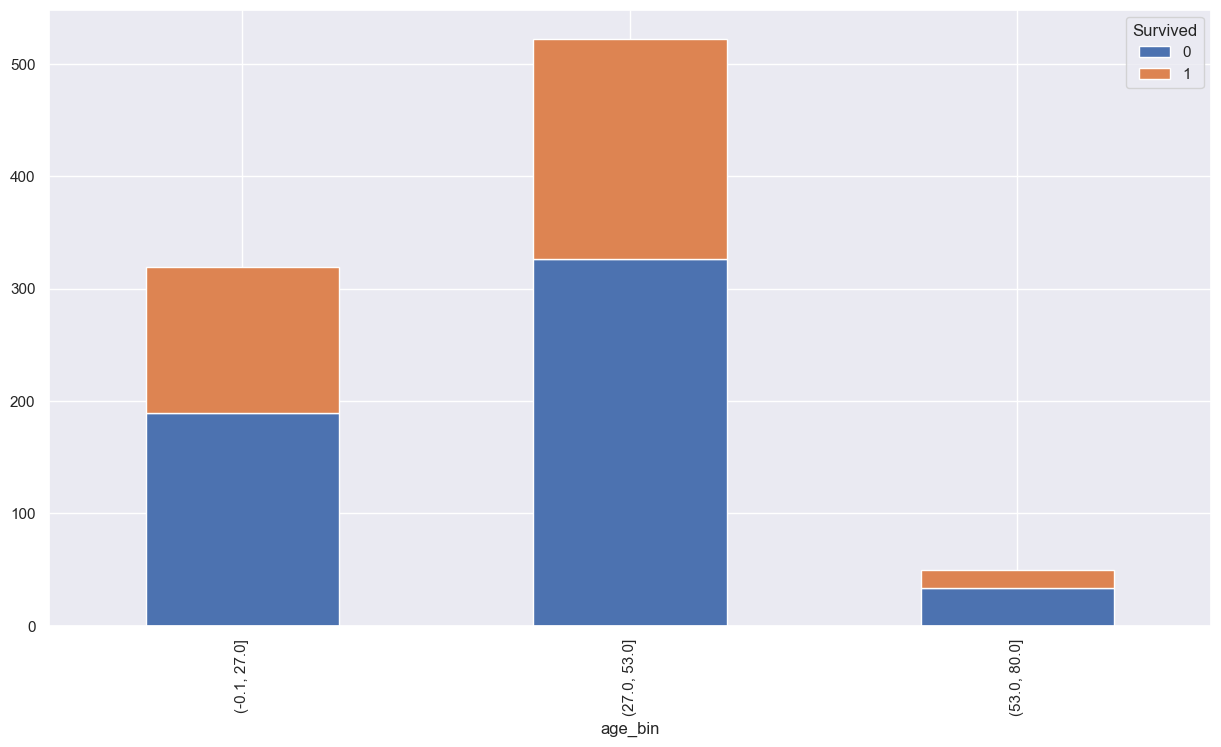

In [31]:
sns.set(rc = {'figure.figsize':(15,8)})

#Find the bins
data['age_bin'] = pd.cut(data['Age'], 3, precision = 0)

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'age_bin']).size().reset_index().pivot(columns='Survived', index='age_bin', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

In [34]:
def drop_outliers(data , col):
    Q1 = data['Age'].quantile(0.25)
    Q3 = data['Age'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (data['Age'] >= Q1 - 1.5 * IQR) & (data['Age'] <= Q3 + 1.5 *IQR) #filter filters out data within Q1 - 1.5*IQR to Q3 + 1.5*IQR
    data = data.loc[filter]
    return data

data = drop_outliers(data , 'Age')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S,"(-0.1, 27.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,"(27.0, 53.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S,"(-0.1, 27.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,"(27.0, 53.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S,"(27.0, 53.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,nan,S,"(27.0, 53.0]"
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,"(-0.1, 27.0]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,nan,S,"(27.0, 53.0]"
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C,"(-0.1, 27.0]"


##### We have 825 rows now that 66 rows containing age outliers were removed

# Sex of the surviors 

Survived    0    1
Sex               
female     76  218
male      435   96


Text(0.5, 0, 'Sex')

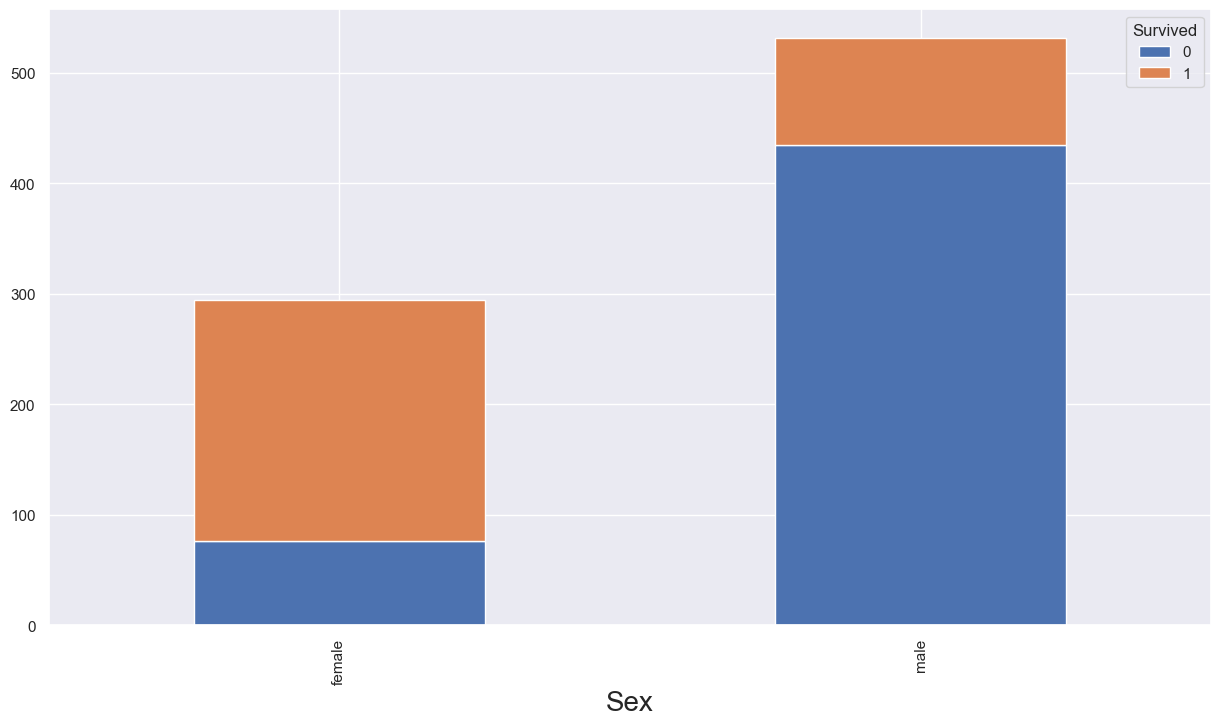

In [36]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Sex']).size().reset_index().pivot(columns='Survived', index='Sex', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Sex", fontsize = 20)

##### From the above stacked plots, it is clear more percentage of female passengers survived i.e. 74.2 % while only 18.9 % of male passengers survived, even though more male passesngers were aboard

In [37]:
data = drop_outliers(data , 'Sex')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S,"(-0.1, 27.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,"(27.0, 53.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S,"(-0.1, 27.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,"(27.0, 53.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S,"(27.0, 53.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,nan,S,"(27.0, 53.0]"
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,"(-0.1, 27.0]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,nan,S,"(27.0, 53.0]"
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C,"(-0.1, 27.0]"


# Fares of the survivors

C:\Users\SAI\AppData\Local\Temp\ipykernel_5440\887329757.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'Density plot')

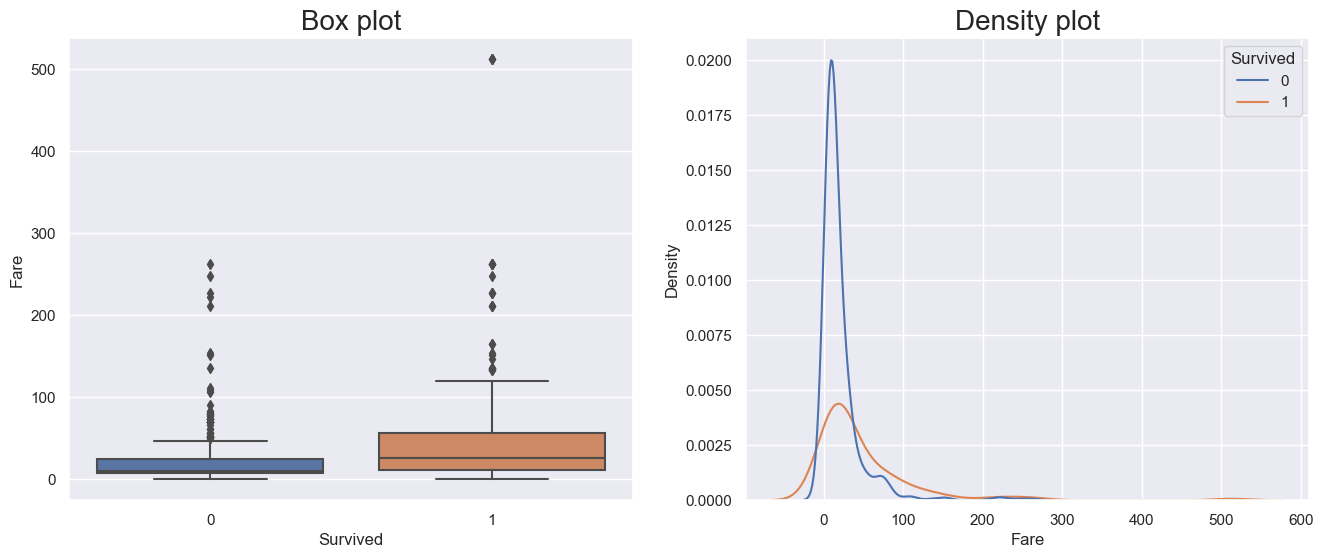

In [38]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="Fare", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
plt.subplot(1,2,2)
dp_ax = sns.kdeplot(x = 'Fare', hue = 'Survived', data = data)
dp_ax.set_title('Density plot', fontsize = 20)

##### 1. Distribution of fares of survivors clearly has a higher median value, hence passengers who survived had higher average fares
##### 2. Lots of outliers in the distribution of both
##### 3. A huge spike in the pdf of the people who didn't survive, or the probability that the person who didn't survive had a fare of ~10 units of currency is very high

In [39]:
data = drop_outliers(data , 'Fare')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S,"(-0.1, 27.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,"(27.0, 53.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S,"(-0.1, 27.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,"(27.0, 53.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S,"(27.0, 53.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,nan,S,"(27.0, 53.0]"
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S,"(-0.1, 27.0]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,nan,S,"(27.0, 53.0]"
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C,"(-0.1, 27.0]"


# Converting fares into categorical variables

In [ ]:
def fares_categorical(data):
    data['fare_bin'] = pd.cut(data['Fare'], 3, precision = 0)
    return data

data = fares_categorical(data)
map_obj = {(-1.0, 171.0) : 0, (171.0, 342.0): 1,(342.0, 512.0):2}
data['fare_bin'] = data['fare_bin'].map(lambda x: map_obj[(x.left, x.right)])

C:\Users\SAI\AppData\Local\Temp\ipykernel_5440\455119832.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'Box plot')

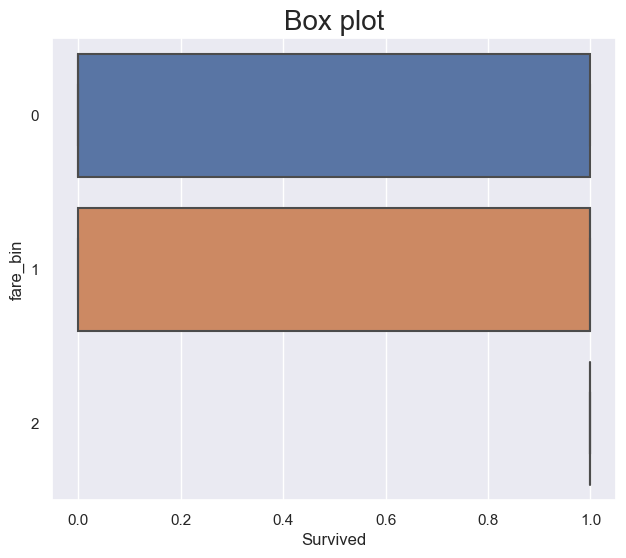

In [41]:
sns.set(rc = {'figure.figsize':(16,6)})
plt.plot(figure_size = (1,2))

#Boxplots
plt.subplot(1,2,1)
bp_ax = sns.boxplot(x = "Survived",y="fare_bin", data = data)
bp_ax.set_title('Box plot', fontsize = 20)

#Density plots
#plt.subplot(1,2,2)
#dp_ax = sns.kdeplot(x = 'fare_bin', hue = 'Survived', data = data)
#dp_ax.set_title('Density plot', fontsize = 20)

# Port embarked of survivors

Survived    0    1
Embarked          
C          65   73
Q          41   30
S         378  174


Text(0.5, 0, 'Embarked')

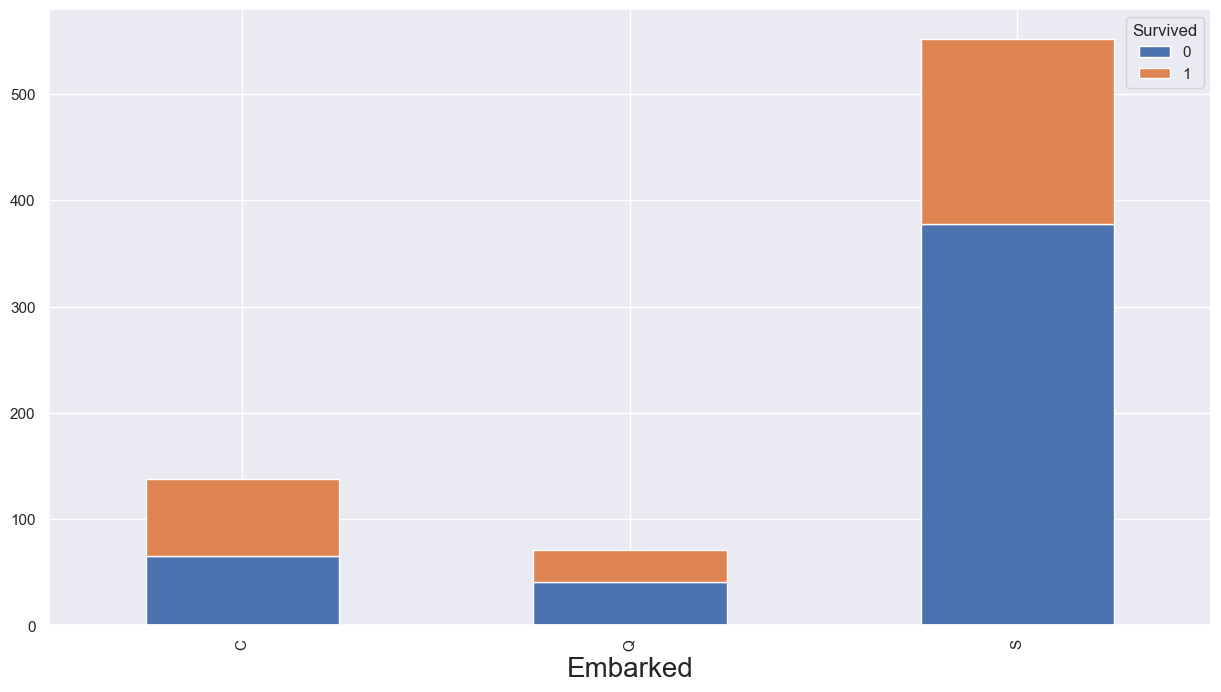

In [43]:
sns.set(rc = {'figure.figsize':(15,8)})

#Calculate the counts of categorical variable Survived for different age bins
df_plot = data.groupby([ 'Survived', 'Embarked']).size().reset_index().pivot(columns='Survived', index='Embarked', values=0)
print(df_plot)

#Plot the stacked bar plot
df_p = df_plot.plot(kind='bar', stacked=True)

#Set labels
df_p.set_xlabel("Embarked", fontsize = 20)

# Name of the survivors

### Name Title

In [44]:
data['Name'].value_counts()

Name
Braund, Mr. Owen Harris                                                               1
Jacobsohn, Mrs. Sidney Samuel (Amy Frances Christy)                                   1
Gilinski, Mr. Eliezer                                                                 1
Murdlin, Mr. Joseph                                                                   1
Rintamaki, Mr. Matti                                                                  1
                                                                                     ..
Keane, Miss. Nora A                                                                   1
Williams, Mr. Howard Hugh "Harry"                                                     1
Fleming, Miss. Margaret                                                               1
Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)    1
Dooley, Mr. Patrick                                                                   1
Name: count, Length: 761, d

In [45]:
data_name_title_1 = data[data['Name'].str.contains('Miss')]['Name']
data_name_title_2 = data[data['Name'].str.contains('Mrs')]['Name']
data_name_title_3 = data[data['Name'].str.contains('Master')]['Name']
data_name_title_4 = data[data['Name'].str.contains('Mr')]['Name']
data_name_title_5 = data[~ (data['Name'].str.contains('Miss') | data['Name'].str.contains('Mrs') | data['Name'].str.contains('Mr') | data['Name'].str.contains('Master'))]['Name']
data_name_title_5.value_counts()

Name
Uruchurtu, Don. Manuel E                                    1
Byles, Rev. Thomas Roussel Davids                           1
Minahan, Dr. William Edward                                 1
Aubart, Mme. Leontine Pauline                               1
Pain, Dr. Alfred                                            1
Reynaldo, Ms. Encarnacion                                   1
Butt, Major. Archibald Willingham                           1
Stahelin-Maeglin, Dr. Max                                   1
Sagesser, Mlle. Emma                                        1
Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)    1
Brewe, Dr. Arthur Jackson                                   1
Reuchlin, Jonkheer. John George                             1
Harper, Rev. John                                           1
Montvila, Rev. Juozas                                       1
Name: count, dtype: int64

## Data Distributions using histograms and box plots.

### Histograms 

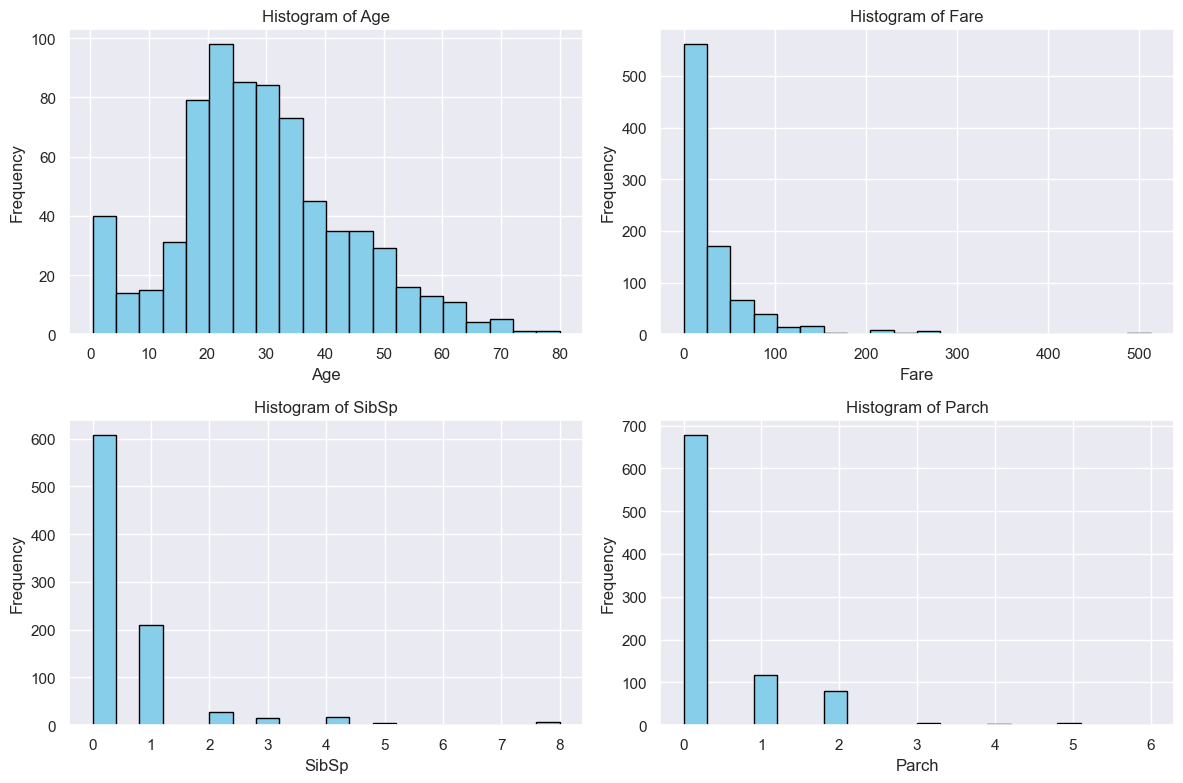

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame, replace 'your_data.csv' with your file path
data = pd.read_csv('Titanic_train.csv')

# List of numerical columns to explore
numerical_columns = ['Age', 'Fare', 'SibSp', 'Parch']

# Plot histograms for each numerical column
plt.figure(figsize=(12, 8))

for i, column_name in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns)//2, i)
    plt.hist(data[column_name].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of {}'.format(column_name))
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()


## Box Plots

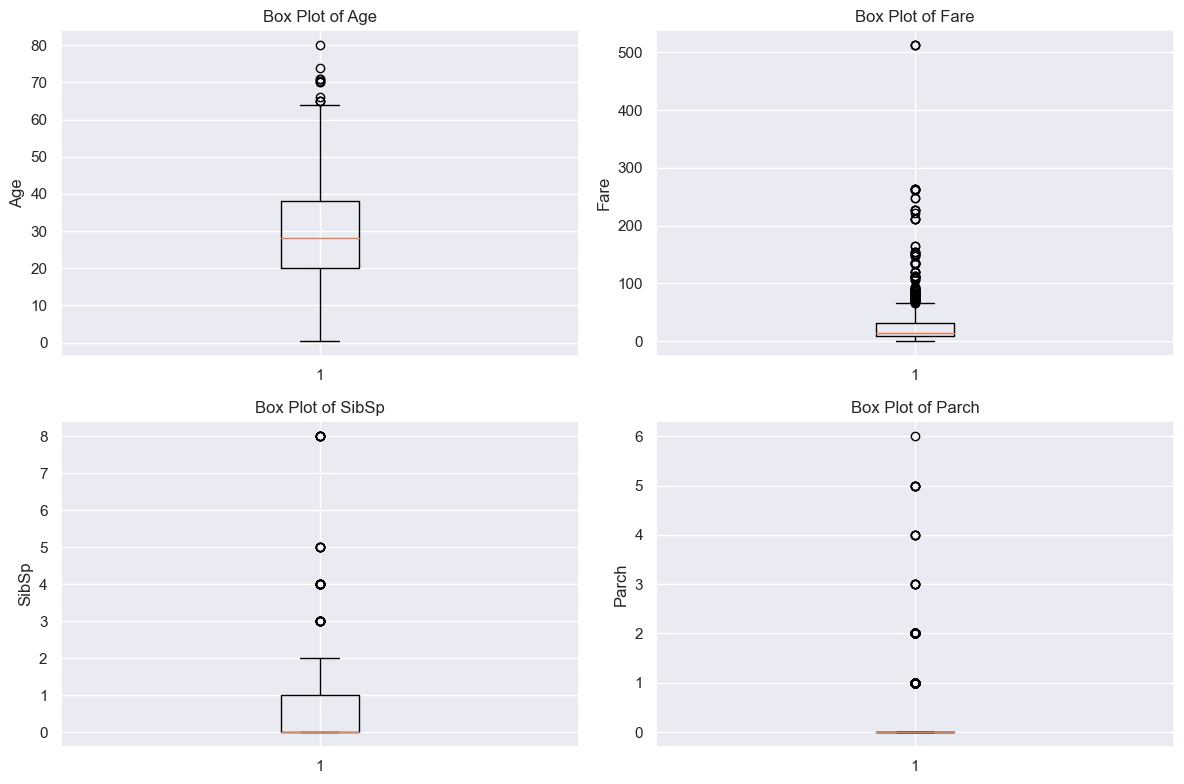

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame, replace 'your_data.csv' with your file path
data = pd.read_csv('Titanic_train.csv')

# List of numerical columns to explore
numerical_columns = ['Age', 'Fare', 'SibSp', 'Parch']

# Plot box plots for each numerical column
plt.figure(figsize=(12, 8))

for i, column_name in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns)//2, i)
    plt.boxplot(data[column_name].dropna())
    plt.title('Box Plot of {}'.format(column_name))
    plt.ylabel(column_name)
    plt.grid(True)

plt.tight_layout()
plt.show()


### Relationships between features and survival using scatter plots and bar plots.

#### 1. Scatter Plots

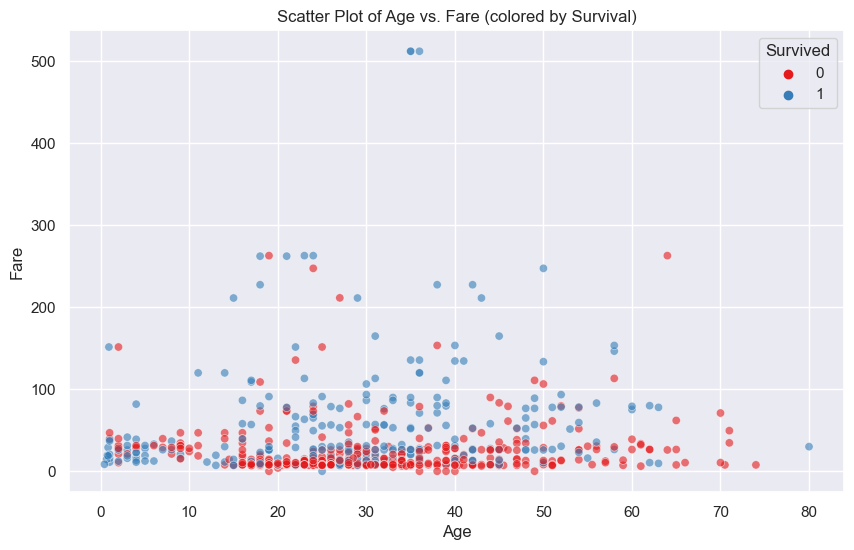

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your DataFrame, replace 'your_data.csv' with your file path
data = pd.read_csv('Titanic_train.csv')

# Scatter plot of Age vs. Fare colored by Survival
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Age', y='Fare', hue='Survived', palette='Set1', alpha=0.6)
plt.title('Scatter Plot of Age vs. Fare (colored by Survival)')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend(title='Survived', loc='upper right')
plt.grid(True)
plt.show()


### This code generates a scatter plot of Age vs. Fare, with points colored by survival status.

### 2. Bar Plots

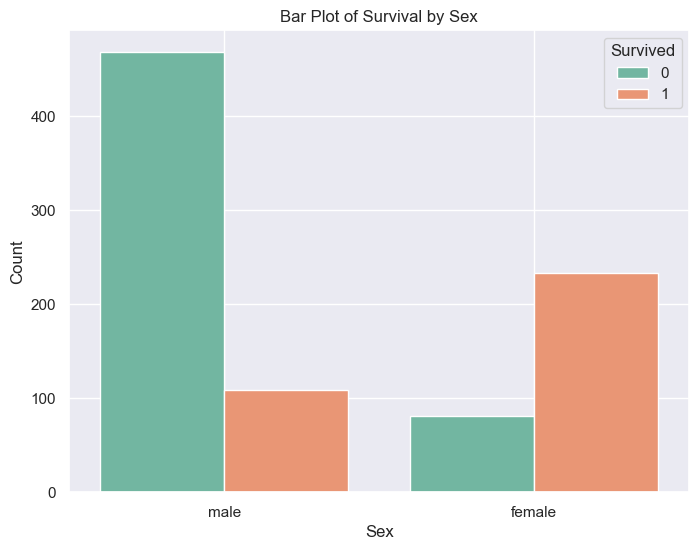

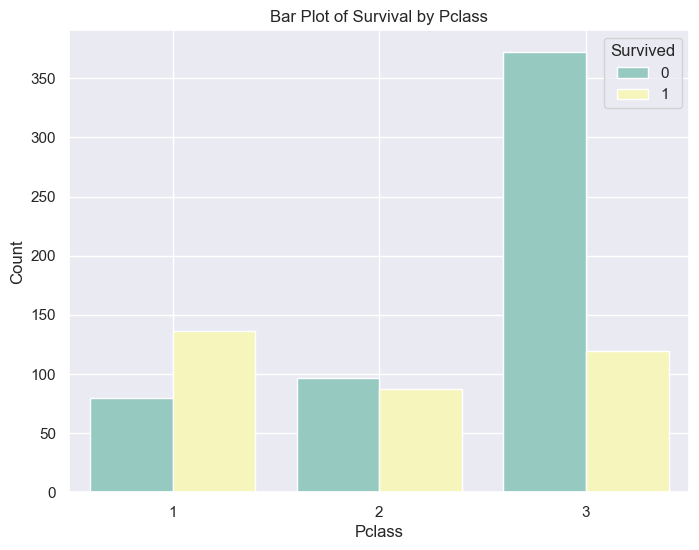

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your DataFrame, replace 'your_data.csv' with your file path
data = pd.read_csv('Titanic_train.csv')

# Bar plot of Survival by Sex
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Sex', hue='Survived', palette='Set2')
plt.title('Bar Plot of Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.grid(True)
plt.show()

# Bar plot of Survival by Pclass
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Pclass', hue='Survived', palette='Set3')
plt.title('Bar Plot of Survival by Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.grid(True)
plt.show()


### This code generates two bar plots: one showing survival counts by Sex and another showing survival counts by Passenger Class (Pclass).

# Data Preprocessing

In [74]:
#Checking for Nan values in features excluding PassengerId, Name
print('Nan values exist in')
for col in [data.columns[i] for i in range(0, len(data.columns))]: #[1,2,4,5,6,7,8,9,10,11]]:
    print(col,':', any(data[col].isna()))

Nan values exist in
PassengerId : False
Survived : False
Pclass : False
Name : False
Sex : False
Age : True
SibSp : False
Parch : False
Ticket : False
Fare : False
Cabin : True
Embarked : True


### 'Age', 'Cabin' and 'Embarked' have Nan values. Lets check them further.

# Age

In [77]:
data['Age'] = data['Age'].fillna('nan')
print(data[data['Age'] == 'nan']['Age'])

5      nan
17     nan
19     nan
26     nan
28     nan
      ... 
859    nan
863    nan
868    nan
878    nan
888    nan
Name: Age, Length: 177, dtype: object


### There are 177 Nan values in the Age column.

### Now, we impute the missing values with a central tendency measure (median performed the best in this case)

In [78]:
# Assuming your DataFrame is named 'data'
median_age = data['Age'].median()
data['Age'] = data['Age'].fillna(median_age)

# Verify that there are no missing values in the 'Age' column
print(data['Age'].isnull().sum())

0


In [80]:
#Imputing mean values for missing data
data = impute_missing_data(data, 'Age', median =True, mode=False)
any(data['Age'].isna())
data['Age'] = data['Age'].map(lambda x: int(x))
'''data = data.drop(data[data['Age']== 'nan'].index, axis= 0)
data.info()'''

"data = data.drop(data[data['Age']== 'nan'].index, axis= 0)\ndata.info()"

### Cabin

In [81]:
data['Cabin'] = data['Cabin'].fillna('nan')
print(data[data['Cabin'] == 'nan']['Cabin'])

0      nan
2      nan
4      nan
5      nan
7      nan
      ... 
884    nan
885    nan
886    nan
888    nan
890    nan
Name: Cabin, Length: 687, dtype: object


#### Only two nan values, we impute them with the maximum occuring category for the feature or the mode.

In [ ]:
#Imputing the mode values for missing data
data = impute_missing_data(data, 'Embarked', median = False, mode = True)

In [82]:
any(data['Embarked'].isna())

True

In [83]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,nan,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,nan,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28,1,2,W./C. 6607,23.4500,nan,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C148,C


### variables using one-hot encoding or label encoding. 

### One-Hot Encoding: 
#### It converts categorical variables into a binary format where each category becomes a separate binary feature. For each category, one feature is hot (1) while the others are cold (0). This encoding preserves the categorical information and is commonly used in machine learning for non-ordinal categorical data.

In [94]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# DataFrame with categorical variable
data = {'category': ['A', 'B', 'C', 'A', 'B', 'C']}
data = pd.read_csv("Titanic_train.csv")

# One-Hot Encoding function
def one_hot_encoding(df):
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df[['category']])
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['category']))
    return encoded_df

# Main function for one-hot encoding
def main_one_hot_encoding():
    print("Original DataFrame:")
    print(df)

    print("\nOne-Hot Encoded DataFrame:")
    one_hot_encoded_df = one_hot_encoding(df)
    print(one_hot_encoded_df)

if __name__ == "__main__":
    main_one_hot_encoding()


Original DataFrame:
  category
0        A
1        B
2        C
3        A
4        B
5        C

One-Hot Encoded DataFrame:
   category_A  category_B  category_C
0         1.0         0.0         0.0
1         0.0         1.0         0.0
2         0.0         0.0         1.0
3         1.0         0.0         0.0
4         0.0         1.0         0.0
5         0.0         0.0         1.0


### Label Encoding
#### Label encoding is a method of transforming categorical data into numerical labels. Each unique category is assigned an integer label. It's useful when there's an ordinal relationship between categories. However, it may introduce unintended ordinality and might not be suitable for non-ordinal categories in machine learning tasks.

In [95]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# DataFrame with categorical variable
data = {'category': ['A', 'B', 'C', 'A', 'B', 'C']}
data = pd.read_csv("Titanic_train.csv")

# Label Encoding function
def label_encoding(df):
    encoder = LabelEncoder()
    encoded_data = encoder.fit_transform(df['category'])
    encoded_df = pd.DataFrame(encoded_data, columns=['category_encoded'])
    return encoded_df

# Main function for label encoding
def main_label_encoding():
    print("Original DataFrame:")
    print(df)

    print("\nLabel Encoded DataFrame:")
    label_encoded_df = label_encoding(df)
    print(label_encoded_df)

if __name__ == "__main__":
    main_label_encoding()


Original DataFrame:
  category
0        A
1        B
2        C
3        A
4        B
5        C

Label Encoded DataFrame:
   category_encoded
0                 0
1                 1
2                 2
3                 0
4                 1
5                 2


#### More preprocessing methods:-  

### Categorical Encoding:
#### Involves converting categorical variables into numerical representations. It's essential for machine learning models as they typically only accept numerical inputs. Common methods include one-hot encoding and label encoding. Below is a Python program demonstrating both encoding techniques:

In [96]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# DataFrame with categorical variable
data = {'category': ['A', 'B', 'C', 'A', 'B', 'C']}
data = pd.read_csv("Titanic_train.csv")

# One-Hot Encoding
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df[['category']])
print("One-Hot Encoded:")
print(one_hot_encoded.toarray())

# Label Encoding
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['category'])
print("\nLabel Encoded:")
print(label_encoded)


One-Hot Encoded:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Label Encoded:
[0 1 2 0 1 2]


### Feature selection:
#### Involves selecting the most relevant features to improve model performance and reduce overfitting. Techniques include correlation analysis, feature importance from tree-based models, or model-based selection. Below is a Python program demonstrating feature selection using correlation analysis:

In [98]:
import pandas as pd

# Sample DataFrame
data = {'feature1': [1, 2, 3, 4, 5],
        'feature2': [5, 4, 3, 2, 1],
        'target': [0, 1, 0, 1, 0]}
data = pd.read_csv("Titanic_train.csv")

# Correlation analysis
correlation_matrix = df.corr()
selected_features = correlation_matrix['target'].abs().sort_values(ascending=False).index[1:]
print("Selected Features:")
print(selected_features)


Selected Features:
Index(['feature1', 'feature2'], dtype='object')


# Tickets of survivors

In [100]:
data_ticket_1 = data[data['Ticket'].str.isdigit() == True]['Ticket']
print(data_ticket_1)

3      113803
4      373450
5      330877
6       17463
7      349909
        ...  
885    382652
886    211536
887    112053
889    111369
890    370376
Name: Ticket, Length: 661, dtype: object


In [101]:
data_ticket_2 = data[data['Ticket'].str.isdigit() == False]['Ticket']
print(data_ticket_2.value_counts())

Ticket
CA. 2343              7
CA 2144               6
S.O.C. 14879          5
PC 17757              4
LINE                  4
                     ..
F.C.C. 13528          1
SOTON/O.Q. 3101311    1
A/5 3540              1
PC 17610              1
SOTON/OQ 392076       1
Name: count, Length: 167, dtype: int64


In [102]:
data_ticket_2_1 = data_ticket_2[data_ticket_2.str.startswith("C")]
print(data_ticket_2_1, len(data_ticket_2_1))

33           C.A. 24579
56           C.A. 31026
58           C.A. 34651
59              CA 2144
66           C.A. 29395
70           C.A. 33111
71              CA 2144
93            C.A. 2315
127             C 17369
134          C.A. 29178
145          C.A. 33112
159            CA. 2343
161          C.A. 33595
180            CA. 2343
201            CA. 2343
234          C.A. 29566
237          C.A. 31921
265          C.A. 17248
279           C.A. 2673
324            CA. 2343
348          C.A. 37671
365              C 7076
376              C 7077
386             CA 2144
439          C.A. 18723
450          C.A. 34651
472          C.A. 34651
480             CA 2144
489          C.A. 37671
497           C.A. 6212
508              C 4001
516          C.A. 34260
549          C.A. 33112
637          C.A. 31921
649            CA. 2314
672          C.A. 24580
678             CA 2144
683             CA 2144
746           C.A. 2673
788           C.A. 2315
792            CA. 2343
801          C.A

In [103]:
data_ticket_2_2 = data_ticket_2[data_ticket_2.str.startswith("S")]
print(data_ticket_2_2, len(data_ticket_2_2))

2      STON/O2. 3101282
43        SC/Paris 2123
45      S.C./A.4. 23567
67            S.P. 3464
72         S.O.C. 14879
             ...       
827     S.C./PARIS 2079
840    SOTON/O2 3101287
841         S.O./P.P. 3
866       SC/PARIS 2149
884     SOTON/OQ 392076
Name: Ticket, Length: 65, dtype: object 65


In [104]:
data_ticket_2_3 = data_ticket_2[data_ticket_2.str.startswith("P")]
print(data_ticket_2_3, len(data_ticket_2_3))

1       PC 17599
10       PP 9549
30      PC 17601
31      PC 17569
34      PC 17604
         ...    
793     PC 17600
835     PC 17756
853     PC 17592
867     PC 17590
874    P/PP 3381
Name: Ticket, Length: 65, dtype: object 65


In [105]:
data_ticket_2_4 = data_ticket_2[~ (data_ticket_2.str.startswith("C") | data_ticket_2.str.startswith("S") | data_ticket_2.str.startswith("P"))]
print(data_ticket_2_4, len(data_ticket_2_4))

0         A/5 21171
12        A/5. 2151
37       A./5. 2152
51       A/4. 39886
86       W./C. 6608
92      W.E.P. 5734
121       A4. 54510
132       A/5. 3337
147      W./C. 6608
152      A.5. 11206
153        A/5. 851
154       Fa 265302
179            LINE
204        A/5 3540
211    F.C.C. 13528
212       A/5 21174
219       W/C 14208
227       A/5 21173
235      W./C. 6609
242     W./C. 14263
253       A/5. 3336
271            LINE
283      A/5. 10482
302            LINE
304        A/5 2466
314    F.C.C. 13529
320       A/5 21172
421      A/5. 13032
425      A/4. 34244
436      W./C. 6608
440    F.C.C. 13529
454        A/5 2817
458    F.C.C. 13531
464        A/S 2816
482        A/5 3594
488      A.5. 18509
494       A/4 45380
526     W./C. 14258
535    F.C.C. 13529
540       WE/P 5735
565       A/4 48871
574      A/4. 20589
589      A./5. 3235
592        A/5 3902
597            LINE
617       A/5. 3336
668        A/5 3536
671      F.C. 12750
736      W./C. 6608
745       WE/P 5735


In [111]:
import pandas as pd

# DataFrame with 'Ticket' column
data = {'PassengerId': [1, 2, 3, 4, 5],
        'Ticket': ['123456', 'PC 1234', 'C 2345', '345678', 'CA 5678']}
df = pd.DataFrame(data)

# Define the ticket_bin_encoding function
def ticket_bin_encoding(data):
    data['ticket_bin'] = np.nan
    
    data_ticket_1 = data[data['Ticket'].str.isdigit()]['Ticket']
    data_ticket_2 = data[data['Ticket'].str.isdigit() == False]['Ticket']
    
    data.loc[data['Ticket'].isin(data_ticket_1), 'ticket_bin'] = 0
    data.loc[data['Ticket'].isin(data_ticket_2), 'ticket_bin'] = 1
    
    return data

# Apply ticket_bin_encoding to the DataFrame
modified_df = ticket_bin_encoding(df)

# Print the modified DataFrame
print(modified_df)



   PassengerId   Ticket  ticket_bin
0            1   123456         0.0
1            2  PC 1234         1.0
2            3   C 2345         1.0
3            4   345678         0.0
4            5  CA 5678         1.0


DataFrame for plotting:
Survived      0    1
ticket_bin          
0           NaN  3.0
1           2.0  NaN


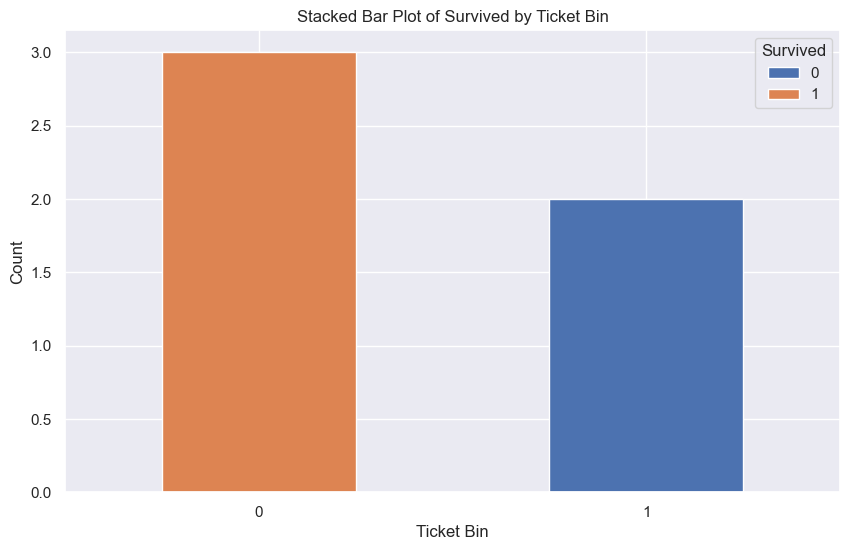

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame with 'Survived' and 'ticket_bin' columns
data = {'PassengerId': [1, 2, 3, 4, 5],
        'Survived': [1, 0, 1, 0, 1],
        'ticket_bin': [0, 1, 0, 1, 0]}
df = pd.DataFrame(data)

# Use groupby on the DataFrame 'df', not on a dictionary
df_plot = df.groupby(['Survived', 'ticket_bin']).size().reset_index().pivot(columns='Survived', index='ticket_bin', values=0)

# Print the resulting DataFrame
print("DataFrame for plotting:")
print(df_plot)

# Plot the stacked bar plot using Seaborn
sns.set(rc={'figure.figsize': (10, 6)})
df_plot.plot(kind='bar', stacked=True)
plt.xlabel('Ticket Bin')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Survived by Ticket Bin')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.legend(title='Survived', loc='upper right')
plt.show()


# Building Predictive Models

### Training and Testing sets.

In [143]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and labels (y)
X = data.drop(columns=['Survived'])  # Assuming 'Survived' is your target column
y = data['Survived']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (712, 12) (712,)
Testing set shape: (179, 12) (179,)


### Evaluation Metrics

### Accuracy:
#### It measures the proportion of correctly predicted instances among the total instances. It's suitable when the class distribution is balanced.

In [148]:
from sklearn.metrics import accuracy_score

# Assuming you have true labels and predicted labels
true_labels = [0, 1, 0, 1, 1]  # Example true labels
predicted_labels = [0, 1, 0, 1, 0]  # Example predicted labels

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)


Accuracy: 0.8


### Precision:
#### It measures the proportion of true positive predictions among the total predicted positives. It's useful when the cost of false positives is high.

In [150]:
def calculate_precision(true_positives, false_positives):
    """
    Calculate the precision of a binary classification model.

    Parameters:
    true_positives (int): The number of true positive predictions
    false_positives (int): The number of false positive predictions

    Returns:
    float: The precision of the model
    """
    try:
        precision = true_positives / (true_positives + false_positives)
    except ZeroDivisionError:
        precision = 0.0
    return precision


true_positives = 50
false_positives = 10

precision = calculate_precision(true_positives, false_positives)
print(f"Precision: {precision:.2f}")


Precision: 0.83


### Recall (Sensitivity): 
#### It measures the proportion of true positive predictions among the actual positives. It's useful when the cost of false negatives is high.

In [151]:
def calculate_recall(true_positives, false_negatives):
    """
    Calculate the recall (sensitivity) of a binary classification model.

    Parameters:
    true_positives (int): The number of true positive predictions
    false_negatives (int): The number of false negative predictions

    Returns:
    float: The recall of the model
    """
    try:
        recall = true_positives / (true_positives + false_negatives)
    except ZeroDivisionError:
        recall = 0.0
    return recall

true_positives = 50
false_negatives = 20

recall = calculate_recall(true_positives, false_negatives)
print(f"Recall: {recall:.2f}")


Recall: 0.71


### F1-score: 
#### It is the harmonic mean of precision and recall, providing a balance between the two metrics. It's useful when you want to consider both precision and recall.

In [152]:
def calculate_f1_score(precision, recall):
    """
    Calculate the F1-score of a binary classification model.

    Parameters:
    precision (float): The precision of the model
    recall (float): The recall of the model

    Returns:
    float: The F1-score of the model
    """
    try:
        f1_score = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = 0.0
    return f1_score

# Example usage
precision = 0.83
recall = 0.71

f1 = calculate_f1_score(precision, recall)
print(f"F1-score: {f1:.2f}")


F1-score: 0.77


### ROC-AUC: 
#### Receiver Operating Characteristic - Area Under Curve measures the area under the ROC curve, which plots the true positive rate against the false positive rate. It's useful for imbalanced datasets.

In [153]:
def calculate_f1_score(precision, recall):
    """
    Calculate the F1-score of a binary classification model.

    Parameters:
    precision (float): The precision of the model
    recall (float): The recall of the model

    Returns:
    float: The F1-score of the model
    """
    try:
        f1_score = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = 0.0
    return f1_score

# Example usage
precision = 0.83
recall = 0.71

f1 = calculate_f1_score(precision, recall)
print(f"F1-score: {f1:.2f}")


F1-score: 0.77


### ROC-AUC: 
#### Receiver Operating Characteristic - Area Under Curve measures the area under the ROC curve, which plots the true positive rate against the false positive rate. It's useful for imbalanced datasets.

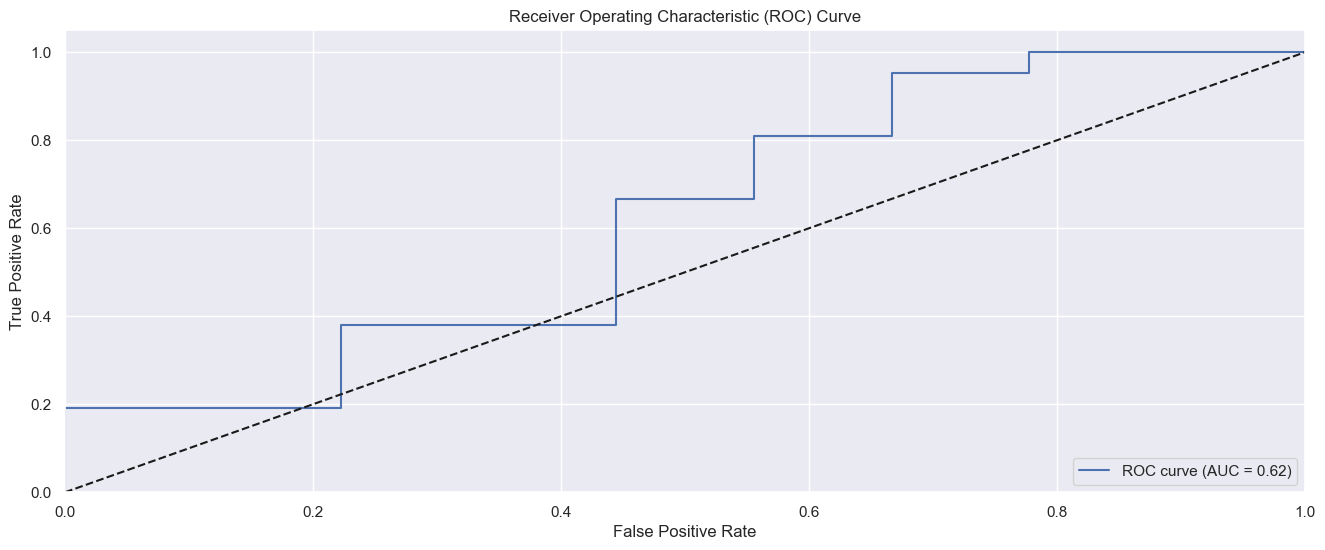

AUC: 0.62


In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Generate data
np.random.seed(0)
X = np.random.rand(100, 2)
y = np.random.randint(0, 2, size=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Only get the probabilities for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the AUC
auc = roc_auc_score(y_test, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {auc:.2f}")


### Confusion Matrix
#### Provides a detailed breakdown of correct and incorrect predictions, showing true positives, true negatives, false positives, and false negatives.

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


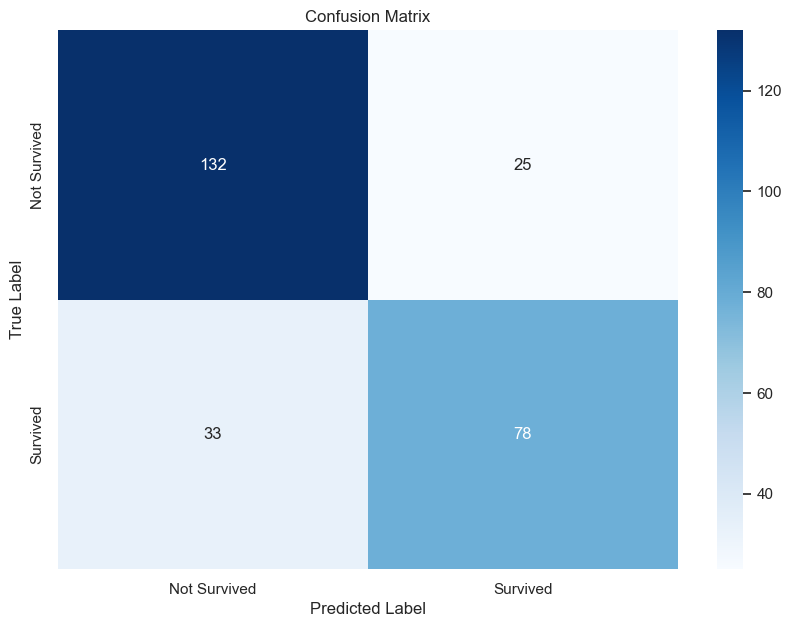

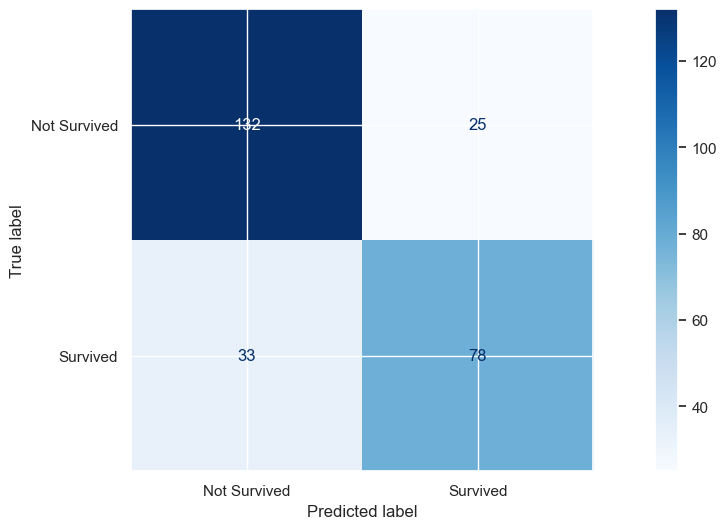

In [162]:


# Load the Titanic dataset
data = pd.read_csv("Titanic_train.csv")

# Display the first few rows of the dataset
print(data.head())

# Data preprocessing
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Drop columns that won't be used
data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

# Encode categorical variables
label_enc = LabelEncoder()
data['Sex'] = label_enc.fit_transform(data['Sex'])
data['Embarked'] = label_enc.fit_transform(data['Embarked'])

# Define features and target variable
X = data.drop(columns=['Survived'])
y = data['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display the confusion matrix using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived'])
disp.plot(cmap='Blues')
plt.show()







## Models using LightGBM and XGBoost algorithms

### LightGBM

In [165]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.3 MB 393.8 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.3 MB 581.0 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.3 MB 599.1 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.3 MB 706.2 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.3 MB 654.4 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.3 MB 842.9 kB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.3 MB 936.6 kB/s eta 0:00:02
   ---------- ----------------------------- 0.3/1.3 MB 901.1 kB/s eta 0:00:02
   ---------- -----------------

In [167]:
pip install lightgbm --upgrade


Note: you may need to restart the kernel to use updated packages.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Tra

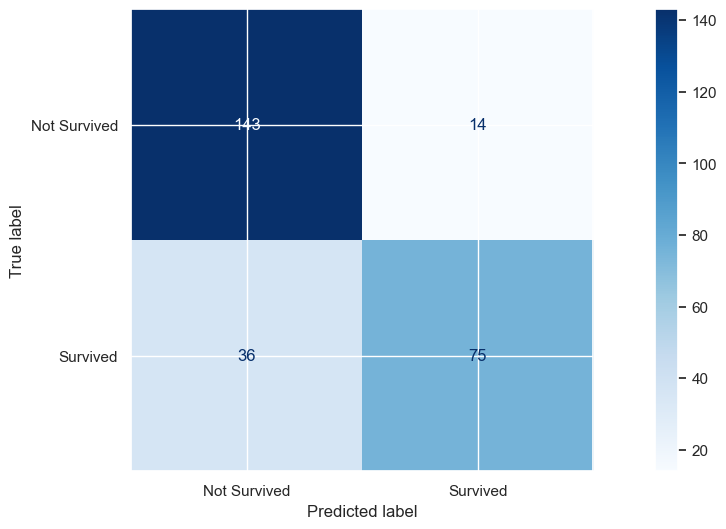

In [174]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier, early_stopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the Titanic dataset
data = pd.read_csv("Titanic_train.csv")

# Data preprocessing
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Drop columns that won't be used
data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

# Encode categorical variables
label_enc = LabelEncoder()
data['Sex'] = label_enc.fit_transform(data['Sex'])
data['Embarked'] = label_enc.fit_transform(data['Embarked'])

# Define features and target variable
X = data.drop(columns=['Survived'])
y = data['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the LGBMClassifier
lgbm_clf = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    n_estimators=100
)

# Train the model with early stopping
lgbm_clf.fit(X_train, y_train, 
             eval_set=[(X_test, y_test)],
             eval_metric='logloss',
             callbacks=[early_stopping(stopping_rounds=10)])

# Predict the labels for the test set
y_pred_lgbm = lgbm_clf.predict(X_test)

# Evaluate the model
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f'LightGBM Accuracy: {accuracy_lgbm:.2f}')

# Calculate the confusion matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Display the confusion matrix using seaborn
ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=['Not Survived', 'Survived']).plot(cmap='Blues')
plt.show()


### xgboost

In [176]:
pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 435.7 kB/s eta 0:03:49
   ---------------------------------------- 0.0/99.8 MB 435.7 kB/s eta 0:03:49
   ---------------------------------------- 0.0/99.8 MB 435.7 kB/s eta 0:03:49
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   ---------------------------------------- 0.0/99.8 MB 151.3 kB/s eta 0:10:59
   -----------------------------

[0]	validation_0-logloss:0.65905
[1]	validation_0-logloss:0.63881
[2]	validation_0-logloss:0.62070
[3]	validation_0-logloss:0.60452
[4]	validation_0-logloss:0.58994
[5]	validation_0-logloss:0.57676
[6]	validation_0-logloss:0.56483
[7]	validation_0-logloss:0.55454
[8]	validation_0-logloss:0.54521
[9]	validation_0-logloss:0.53611
[10]	validation_0-logloss:0.52805
[11]	validation_0-logloss:0.52053
[12]	validation_0-logloss:0.51426
[13]	validation_0-logloss:0.50804
[14]	validation_0-logloss:0.50200


C:\Users\SAI\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-logloss:0.49643
[16]	validation_0-logloss:0.49118
[17]	validation_0-logloss:0.48715
[18]	validation_0-logloss:0.48265
[19]	validation_0-logloss:0.47882
[20]	validation_0-logloss:0.47512
[21]	validation_0-logloss:0.47192
[22]	validation_0-logloss:0.46964
[23]	validation_0-logloss:0.46592
[24]	validation_0-logloss:0.46278
[25]	validation_0-logloss:0.46041
[26]	validation_0-logloss:0.45853
[27]	validation_0-logloss:0.45537
[28]	validation_0-logloss:0.45289
[29]	validation_0-logloss:0.45006
[30]	validation_0-logloss:0.44926
[31]	validation_0-logloss:0.44783
[32]	validation_0-logloss:0.44597
[33]	validation_0-logloss:0.44534
[34]	validation_0-logloss:0.44475
[35]	validation_0-logloss:0.44444
[36]	validation_0-logloss:0.44408
[37]	validation_0-logloss:0.44392
[38]	validation_0-logloss:0.44347
[39]	validation_0-logloss:0.44399
[40]	validation_0-logloss:0.44349
[41]	validation_0-logloss:0.44278
[42]	validation_0-logloss:0.44279
[43]	validation_0-logloss:0.44231
[44]	validatio

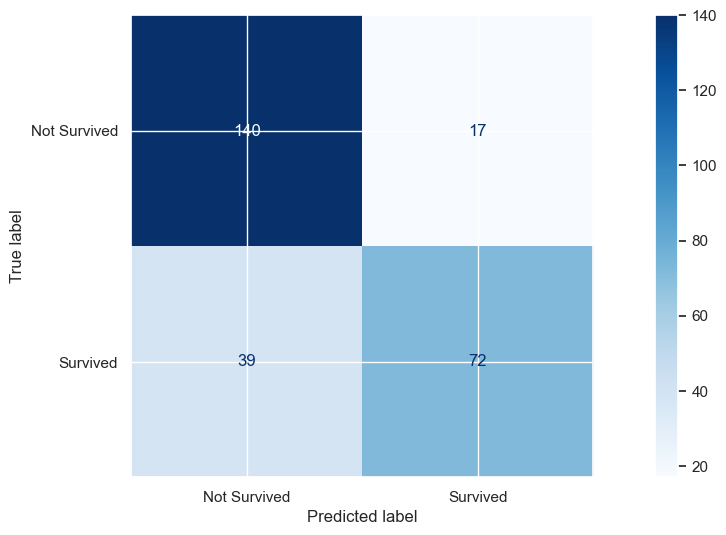

In [177]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the Titanic dataset
data = pd.read_csv("Titanic_train.csv")

# Data preprocessing
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Drop columns that won't be used
data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

# Encode categorical variables
label_enc = LabelEncoder()
data['Sex'] = label_enc.fit_transform(data['Sex'])
data['Embarked'] = label_enc.fit_transform(data['Embarked'])

# Define features and target variable
X = data.drop(columns=['Survived'])
y = data['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=5,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model with early stopping
xgb_clf.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=10,
            verbose=True)

# Predict the labels for the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')

# Calculate the confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Display the confusion matrix using seaborn
ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Not Survived', 'Survived']).plot(cmap='Blues')
plt.show()


## Train the models on the training set and evaluate their performance on the testing set.

## 1. Data Preprocessing: 
#### This step involves cleaning the data, handling missing values, encoding categorical variables, scaling numerical features, and splitting the data into training and testing sets.

In [181]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming X_train, X_test, y_train, y_test are your data
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines for numerical and categorical data
numeric_features = [0, 1, 2]  # indices of numerical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [3, 4]  # Assuming these are the indices of categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Full preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocess training data
X_train_preprocessed = pipeline.fit_transform(X_train)

# Preprocess testing data
X_test_preprocessed = pipeline.transform(X_test)

# Initialize models
linear_reg = LinearRegression()
random_forest_reg = RandomForestRegressor()

# Train models
linear_reg.fit(X_train_preprocessed, y_train)
random_forest_reg.fit(X_train_preprocessed, y_train)

# Evaluate models
y_pred_linear_reg = linear_reg.predict(X_test_preprocessed)
linear_reg_rmse = mean_squared_error(y_test, y_pred_linear_reg, squared=False)

y_pred_random_forest_reg = random_forest_reg.predict(X_test_preprocessed)
random_forest_rmse = mean_squared_error(y_test, y_pred_random_forest_reg, squared=False)

print("Linear Regression RMSE:", linear_reg_rmse)
print("Random Forest Regression RMSE:", random_forest_rmse)


Linear Regression RMSE: 0.37364986372888126
Random Forest Regression RMSE: 0.40015477026251595


## 2. Model Training:
#### Train various machine learning models on the training set. Common models include linear regression, decision trees, random forests, support vector machines, neural networks, etc.



In [183]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset 
data = pd.read_csv("Titanic_train.csv")

# Assuming 'X' contains features and 'y' contains target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Define the classifier model
classifier = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier())])

# Train the model
classifier.fit(X_train, y_train)

# Predict on the testing set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6983240223463687


## 3. Model Evaluation: 
#### Evaluate the trained models on the testing set using appropriate evaluation metrics. The choice of evaluation metric depends on the type of problem (e.g., classification, regression) and the specific requirements of the problem.



In [187]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load dataset
data = pd.read_csv("Titanic_train.csv")


# Check dimensions of X and y
print("Shape of X:", X.shape)
print("Number of classes in y:", len(y.unique()))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression()

# Train the model
log_reg_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = log_reg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Shape of X: (891, 7)
Number of classes in y: 2
Accuracy: 0.8100558659217877


## cross-validation and hyperparameter tuning to optimize model performance.

### Cross-Validation:
#### Cross-validation helps assess how well a model generalizes to new data by splitting the training data into multiple subsets, training the model on a subset, and evaluating it on the remaining data. This process is repeated multiple times, and the average performance is calculated.

In [189]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

# Load dataset 
data = pd.read_csv("Titanic_train.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression()

# Perform cross-validation
cv_scores = cross_val_score(log_reg_model, X_train, y_train, cv=5)  # 5-fold cross-validation
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation scores: [0.82517483 0.81118881 0.78873239 0.73943662 0.8028169 ]
Mean CV accuracy: 0.7934699103713188


C:\Users\SAI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SAI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

## Hyperparameter Tuning: 
#### Hyperparameters are parameters that are set before training a model and cannot be learned from the data. Tuning these hyperparameters can significantly impact the model's performance. Techniques like grid search or random search are commonly used to find the best combination of hyperparameters.

In [190]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Load dataset (replace 'dataset.csv' with the path to your dataset)
data = pd.read_csv("Titanic_train.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression()

# Define hyperparameters grid for grid search
param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters on the testing set
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy on testing set:", accuracy)


C:\Users\SAI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SAI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy on testing set: 0.8100558659217877


C:\Users\SAI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SAI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

# Comparative Analysis

### Compare the performance metrics (e.g., accuracy, precision, recall) of LightGBM and XGBoost models.

## LightGBM

In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import lightgbm as lgb

# Load dataset 
data = pd.read_csv("Titanic_train.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier()

# Train LightGBM model
lgb_model.fit(X_train, y_train)

# Evaluate LightGBM model
lgb_y_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
lgb_precision = precision_score(y_test, lgb_y_pred)
lgb_recall = recall_score(y_test, lgb_y_pred)

# Print performance metrics for LightGBM
print("LightGBM Performance Metrics:")
print("Accuracy:", lgb_accuracy)
print("Precision:", lgb_precision)
print("Recall:", lgb_recall)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## XGBoost Model

In [192]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

# Load dataset
data = pd.read_csv("Titanic_train.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier()

# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost model
xgb_y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)

# Print performance metrics for XGBoost
print("XGBoost Performance Metrics:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)


XGBoost Performance Metrics:
Accuracy: 0.7877094972067039
Precision: 0.7368421052631579
Recall: 0.7567567567567568


## Visualize and interpret the results to identify the strengths and weaknesses of each algorithm.

### > Confusion Matrix:- To see how well the models are performing in terms of true positives, true negatives, false positives, and false negatives.
### > ROC Curve:- To visualize the performance of the models at different threshold levels.
### > Classification Report:- To get detailed metrics like precision, recall, F1-score for each class.

# LightGBM Model:

##### Include visualizations and performance metrics.

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


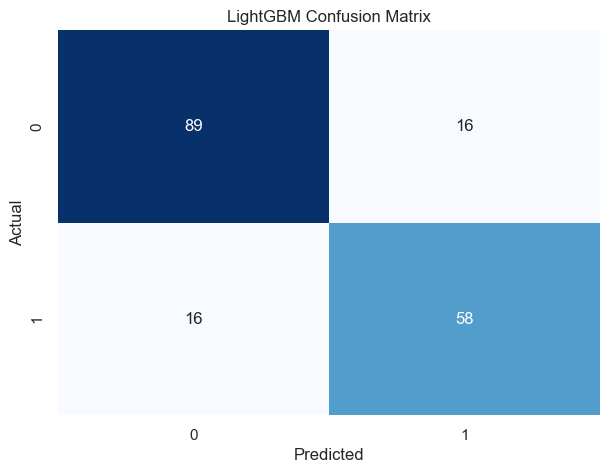

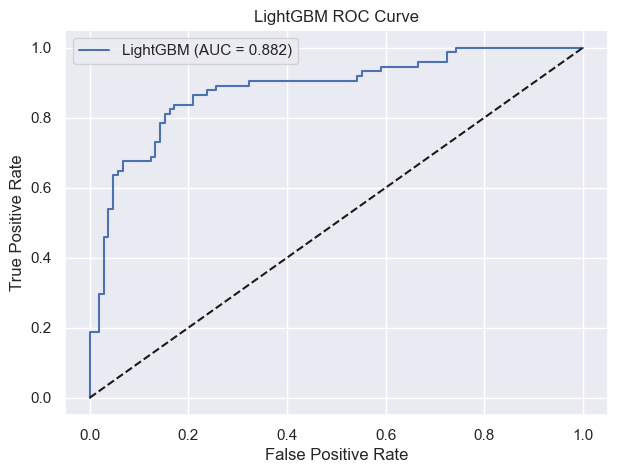

In [193]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset 
data = pd.read_csv("Titanic_train.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier()

# Train LightGBM model
lgb_model.fit(X_train, y_train)

# Predict with LightGBM model
lgb_y_pred = lgb_model.predict(X_test)

# Evaluate LightGBM model
lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
lgb_precision = precision_score(y_test, lgb_y_pred)
lgb_recall = recall_score(y_test, lgb_y_pred)

# Print performance metrics for LightGBM
print("LightGBM Performance Metrics:")
print("Accuracy:", lgb_accuracy)
print("Precision:", lgb_precision)
print("Recall:", lgb_recall)
print("\nClassification Report:\n", classification_report(y_test, lgb_y_pred))

# Confusion Matrix
lgb_cm = confusion_matrix(y_test, lgb_y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(lgb_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
lgb_y_prob = lgb_model.predict_proba(X_test)[:, 1]
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_y_prob)

plt.figure(figsize=(7, 5))
plt.plot(lgb_fpr, lgb_tpr, label='LightGBM (AUC = {:.3f})'.format(roc_auc_score(y_test, lgb_y_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend()
plt.show()


# XGBoost Model:

XGBoost Performance Metrics:
Accuracy: 0.7877094972067039
Precision: 0.7368421052631579
Recall: 0.7567567567567568

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       105
           1       0.74      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



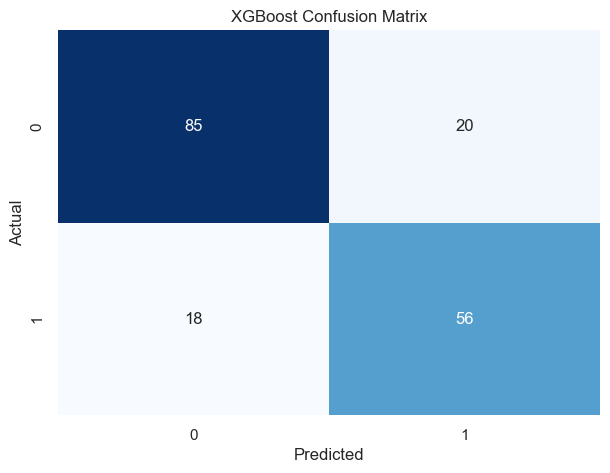

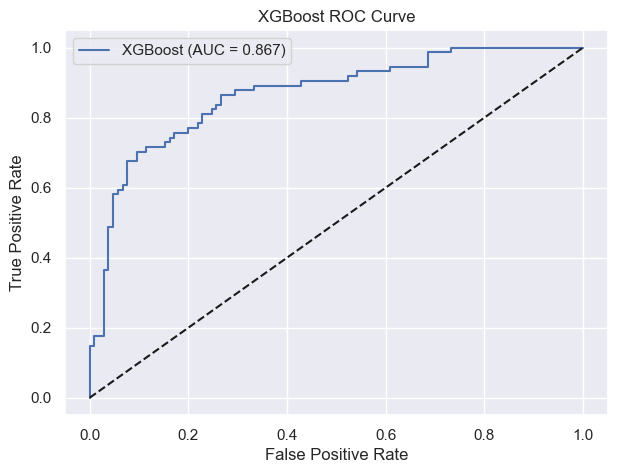

In [194]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset 
data = pd.read_csv("Titanic_train.csv")


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier()

# Train XGBoost model
xgb_model.fit(X_train, y_train)

# Predict with XGBoost model
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)

# Print performance metrics for XGBoost
print("XGBoost Performance Metrics:")
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("\nClassification Report:\n", classification_report(y_test, xgb_y_pred))

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
xgb_y_prob = xgb_model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_prob)

plt.figure(figsize=(7, 5))
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC = {:.3f})'.format(roc_auc_score(y_test, xgb_y_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()
plt.show()
